# Week 11 Midterm: NLP

**Brian Roepke**  
*DATA 110*

# Overview

As a clothing retailer with an e-Commerce presence, it's important for us to understand what customers are saying about our products, which products are most popular with our customers, and how we can improve our offerings.  To accomplish this we'll take a look at several different analyses that will help with the following:

1. **Review Trends**: General trends of customer reviews, quantity, distribution, etc.
1. **Sentiment Analysis**:  How customers feel about the products; are they positive or negative generally.
1. **Part of Speech Analysis**: Using different parts of speech (Nouns, Verbs, Adjectives, etc.).  Via this, we can see the most common positive and negative words used to describe products as well as which a the most commonly referenced products categories.
1. **Recommendation Prediction**: We will use this customer sentiment to understand better if a customer will give a positive rating on the clothing items based on their review.
1. **Department Prediction**: Finally, we'll use a multi-label classification model to predict the departments a product belongs to based on the description that's being used.  This might identify cross-selling opportunities or cross-listing opportunities for products in new categories.

![](https://github.com/broepke/DATA110/blob/main/Week%2011/clothing.jpg?raw=true)
<a href='https://www.freepik.com/vectors/woman'>Woman vector created by freepik - www.freepik.com</a>

In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from textblob import Word

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing & EDA

Importing our dataset and providing the necessary cleaning and analysis.

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [4]:
df.shape

(23486, 8)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [5]:
# check for nan/null
df.isnull().values.any()

True

In [6]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name              14
Class Name                   14
dtype: int64

In [7]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

**Note**: The null values for the lower counts (except `Title`) were dropped from the dataset.

In [8]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name               0
Class Name                    0
dtype: int64

In [9]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

**Note**: Any `NULL` values for the title field are filled with blank strings.  Next these will be combined with the `Review Text` field so we have a single text field for analysis.

In [10]:
# count of nulls
df.isnull().sum()

Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Department Name            0
Class Name                 0
dtype: int64

In [11]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [12]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

In [13]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [14]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


**Note**: After the prior clean up of `NULL` values, there were just `2` duplicates left.

### Numeric Variables

In [15]:
df.describe()

,Age,Rating,Recommended IND,Positive Feedback Count,text_len
count,22626.000000,22626.000000,22626.000000,22626.000000,22626.000000
mean,43.283921,4.183020,0.818748,2.632016,326.229515
std,12.328115,1.115934,0.385235,5.787722,147.168583
min,18.000000,1.000000,0.000000,0.000000,12.000000
25%,34.000000,4.000000,1.000000,0.000000,201.000000
50%,41.000000,5.000000,1.000000,1.000000,319.000000
75%,52.000000,5.000000,1.000000,3.000000,478.000000
max,99.000000,5.000000,1.000000,122.000000,557.000000


**Observations:** 

1. The age ranges for the dataset range from `18` to `99` with a mean of `43`.  Most shoppers are middled aged with our store.
1. Ratings are based on `1-5` star system.  Mean rating is `4.18` meaning most people give positive reviews. 
1. Positive feedback count is the number of times that people found a review useful.  the mean is `2.63` with a min of `0` and max of `122`
1. Text lenght will be covered later in EDA

### Categorical Variables

In [16]:
# get categorical data
cat_data = df.select_dtypes(include=['object'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22626 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Department Name  22626 non-null  object
 1   Class Name       22626 non-null  object
 2   Text             22626 non-null  object
dtypes: object(3)
memory usage: 707.1+ KB


In [81]:
print (df['Department Name'].value_counts(), '\n')
print (df['Class Name'].value_counts(), '\n')

[Tops]        10048
[Dresses]     6145 
[Bottoms]     3661 
[Intimate]    1652 
[Jackets]     1002 
[Trend]       118  
Name: Department Name, dtype: int64 

Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1103
Fine gauge        1059
Skirts            903 
Jackets           683 
Lounge            669 
Swim              331 
Outerwear         319 
Shorts            304 
Sleep             214 
Legwear           158 
Intimates         147 
Layering          132 
Trend             118 
Casual bottoms    1   
Chemises          1   
Name: Class Name, dtype: int64 



**Observations:**  

The categorical values are extermely clean and well labled.  We can look at the distributions of these better via visualization in the next section.

## EDA

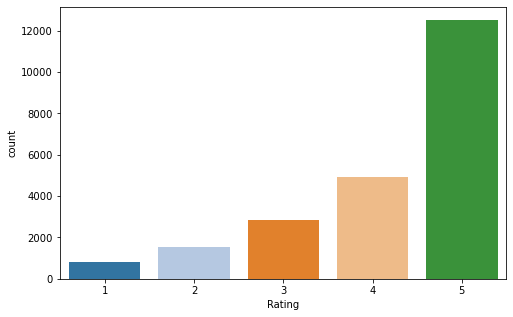

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(x='Rating', data=df, palette="tab20", dodge=False);

**Notes:** As observed in the prior section, the reviews are skewed to the postive.

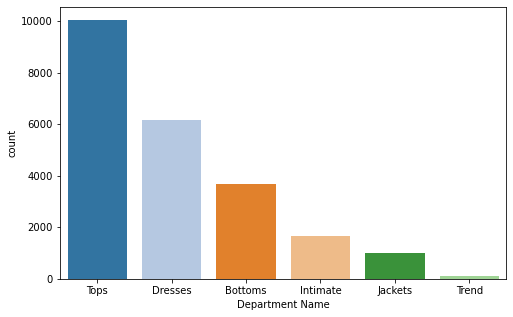

In [19]:
plt.figure(figsize=(8,5))
sns.countplot(x='Department Name', data=df, palette="tab20", 
              order = df['Department Name'].value_counts().index, dodge=False);

**Notes**:  

1. `Tops` followed by `Dresses` are the largest categories.  
1. There are very few `Trend` and `Jackets` in the product line.  Predictions will be harder on these imbalanced classes.

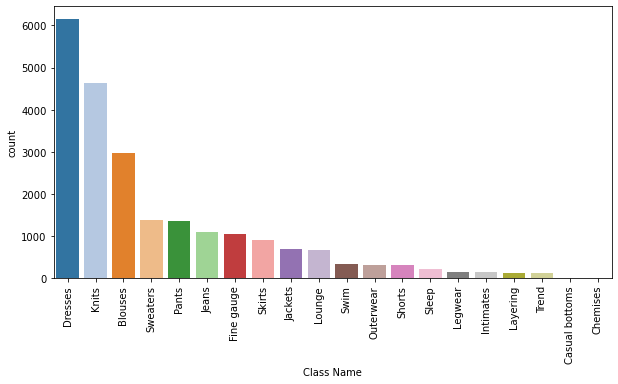

In [20]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Class Name', data=df, palette="tab20", 
                   order = df['Class Name'].value_counts().index, dodge=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

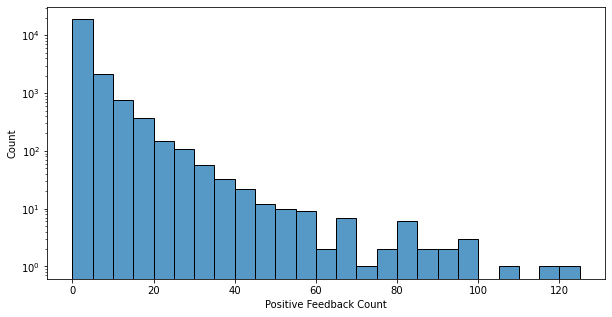

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(df, x='Positive Feedback Count', palette="tab20c", binwidth=5);
ax.set(yscale="log");

**Observations**: 

Most items in the dataset do not have any `Positive Feedback Count` and were set to `0` earlier.  The maximum is `~120`.

Please note the `Y-Axis` as this is on a log scale.

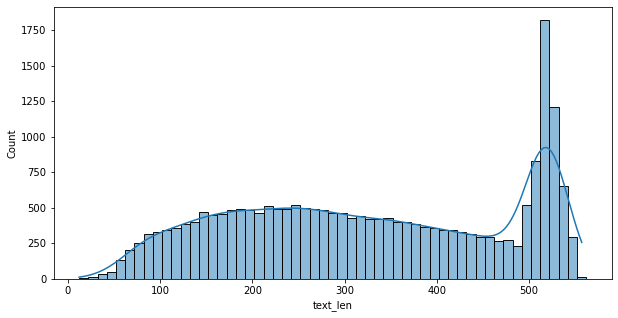

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_len', kde=True, palette="tab20c", binwidth=10);
# ax.set(yscale="log");

**Notes**: For the `text_len` attribute, there is a fairly even distribution from `100` to `400` characters and then a higher concentration of reviews that are longer, around `500` characters.  Given that there are not massive outliers here, the number of characters of the reviews is probably limited to `~600~` chars.

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [23]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [24]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [25]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [26]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Sentiment Analysis

For our sentiment analysis section, we will be using the `TextBlob` package to assist in creating `polarity scores` or sentiment scores that range from `-1` to `1` where lower scores are more negative and higher more positive.  Based off of these scores, we'll add a classifier of `1` for positive and `0` for negative to be used later in our prediction model. 

**Note**: `0` is technically nuetral sentiment, we'll verify how many observations were neutral before assuming we can use a binary label.

In [27]:
def get_sentiment(x):
    '''using TextBlob, get the sentiment score for a given body of text'''
    blob = TextBlob(x)
    return blob.sentiment.polarity

In [28]:
# Apply the Polarity Scoring from TextBlob
df['sentiment'] = df['Text_Processed'].apply(lambda x: get_sentiment(x))

In [29]:
# Create a few extra columns to aid in the analysis
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x >= 0 else 0)

In [30]:
df[df.columns[-4:]].sample(5, random_state=4)

,text_len,Text_Processed,sentiment,sentiment_label
12429,550,detail lace beading design comfortable eyeing ...,0.278788,1
9793,217,run small usually wear size 24 ordered 4 way s...,-0.075000,0
8852,517,disappointed huge fan lovely swing dress last ...,0.070317,1
5600,79,unique style got mustard grey cute looking for...,0.275000,1
14474,212,run large beautiful dress usually wear size 4 ...,0.202381,1


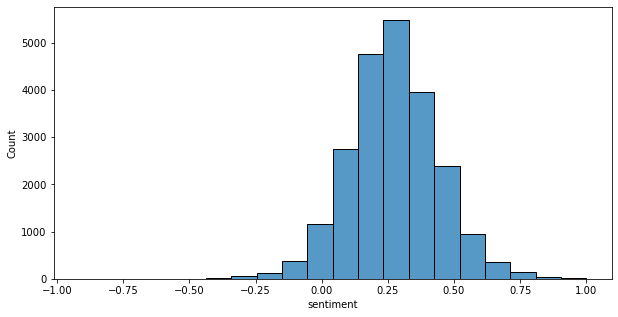

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='sentiment', palette="tab20c", bins=20);

**Observations:**

The distributions of sentiment, similar to the `1-5` star reviews is left skewed to the positive.  There are very few that have a `<0` polartity score.

In [32]:
len(df[df['sentiment'] == 0])

83

**Note**: There are a small number (`83`) of reviews that received a `neutral` sentiment.  Since this number is so low, a `0` rating was grouped together with the majority class (`positive`).

# Part-of-speech Tagging

In this portion of the analysis, we will use a method known as Part of Speech tagging or POS.  This method uses a lexicon-based lookup to identify what parts of speech words are, such as Nouns, Verbs, Adjectives, and Adverbs.  By utilizing these, we can perform various analysis such as the following:

- Word counts for different parts of speech to start giving us an overview of the most common parts of language used.
- Identify nouns used to tag products (e.g., dress, jacket, bottom, etc.).  This will give us a different look at the popularity of items vs. simply counting categories.
- Finally, we'll identify the top adjectives and adverbs for positive vs. negative reviews, telling us what words are used in each sentiment to describe the products.

In [33]:
# Tokenize the words
df['Text_Tok'] = df['Text_Processed'].apply(word_tokenize)

In [34]:
def parse_text(x):
    '''using TextBlob, get the full parsed results (POS, etc)'''
    blob = TextBlob(x)
    p = blob.parse()
    p = re.sub(r'^\w+/', '',p)
    return p.split('/')

In [35]:
def build_pos(x):
    '''pass a DataFrame column with tokenized text and return a DF of the Words'''
    all_words = []
    for l in x:
        all_words = all_words + l
        
    df = pd.DataFrame(all_words)
    df.columns = ['Word']
    
    # Add a column for the POS
    df['Parse'] = df['Word'].apply(lambda x: parse_text(x))
    
    # Expned the extracted list of POS tags into their own columns, and concat that back to the orig DF
    # https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/
    par = pd.DataFrame(df['Parse'].to_list(), columns=['P1','P2', 'P3', 'P4'])
    df = pd.concat([df[:], par[:]], axis=1)
    df.drop(columns=['Parse'], inplace=True)

    return df

In [36]:
df_words = build_pos(df['Text_Tok'])

In [37]:
df_words.sample(10)

,Word,P1,P2,P3,P4
150468,paired,VBN,B-VP,O,None
677734,machine,NN,B-NP,O,None
546479,poof,NN,B-NP,O,None
417969,better,JJR,B-ADJP,O,None
665962,elegant,JJ,B-ADJP,O,None
183282,shrink,VB,B-VP,O,None
24327,keeper,NN,B-NP,O,None
30066,top,JJ,B-ADJP,O,None
694883,maybe,RB,B-ADVP,O,None
678919,im,VBP,B-VP,O,None


**Notes:** Rather than using the much simpler approach of the POS with the TextBlog `tags` function[1], We used the `parse` function since it provides more verbose labeling text.

The attempt here was to discover if there was a better way to identify nouns that would represent product features vs. other nouns.  Unfortunately, this didn't end up providing the detail needed. More information on this is presented below.

## Word Counts for Different Parts of Speech

In [38]:
df_top_pos = df_words.groupby('P1')['P1'].count().\
    reset_index(name='count').sort_values(['count'],ascending=False).head(15)

In [39]:
df_top_pos

,P1,count
10,NN,269428
6,JJ,166542
20,VB,65332
16,RB,54957
21,VBD,37820
23,VBN,23676
1,CD,19369
5,IN,17498
22,VBG,16842
24,VBP,13959


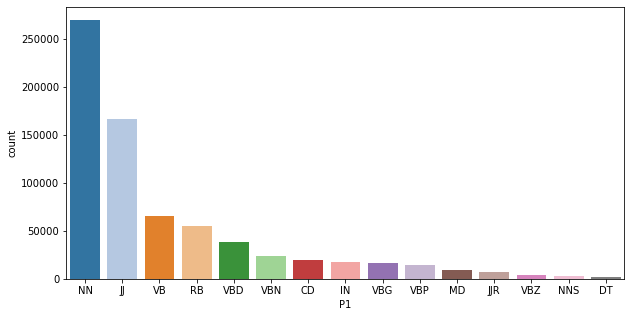

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(data =df_top_pos, x='P1', y='count', palette="tab20");

## Identify Top Product Nouns

In [41]:
df_nn = df_words[df_words['P1'] == 'NN'].copy()

In [42]:
df_nn.groupby('Word')['Word'].count().reset_index(name='count').\
    sort_values(['count'], ascending=False).head(10)

,Word,count
2994,dress,12970
5449,love,10812
8332,size,9572
2151,color,7357
3371,fabric,5127
9078,sweater,3112
8139,shirt,3099
1219,bit,2947
5633,material,2922
4851,jean,2848


**Notes**:  When inspecting `nouns` only, there is a mix of different types of words displayed, and some we can see are not tagged in such a way that seems to make sense with this dataset.  For example, `love` is tagged as a noun, but it's probably an adjective.  `bit` is probably referring to an adjective as well but is showing as a noun.

We can inspect these words directly to see if there is a difference in their POS tags.

In [43]:
print(TextBlob('dress').parse())
print(TextBlob('love').parse())
print(TextBlob('bit').parse())

dress/NN/B-NP/O
love/NN/B-NP/O
bit/NN/B-NP/O


**Observations:**  When we try to use the Part of Speech (POS) tagging, there isn't a distinction between Nouns.  Each of these has the same POS sequence. 

We can use the Class name to determine clothing nouns to use.  

In [44]:
# Extract a list of all the unique class names
noun_types = list(df['Class Name'].unique())

# The words from the categories need to be lemmatized.
lem = WordNetLemmatizer()
for i in range(len(noun_types)):
    noun_types[i] = lem.lemmatize(noun_types[i].lower())
noun_types

['intimate',
 'dress',
 'pant',
 'blouse',
 'knit',
 'outerwear',
 'lounge',
 'sweater',
 'skirt',
 'fine gauge',
 'sleep',
 'jacket',
 'swim',
 'trend',
 'jean',
 'legwear',
 'short',
 'layering',
 'casual bottoms',
 'chemise']

In [45]:
# Extract all the text into a huge string and use Text Blobs to get a Dictionary out with counts
all_text = ' '.join(df['Text_Processed'])
all_text_blob = TextBlob(all_text)
all_text_dict = all_text_blob.word_counts

# Turn the dictionary into a Dataframe.  Filter by the word list and then sort for plotting.
df_dict = pd.DataFrame(list(all_text_dict.items()),columns = ['Word','Count']) 
df_products = df_dict[df_dict.Word.isin(noun_types)]
df_products.sort_values(by=['Count'], inplace=True, ascending=False)
df_products

,Word,Count
6,dress,12970
455,sweater,3112
362,jean,2848
460,short,2594
104,skirt,2480
154,pant,2366
512,jacket,1477
340,blouse,1188
506,knit,485
492,layering,258


**Observations**: Based on the top outputs, we can see that `dresses` are the largest mentioned product line at a rate of `4x` the second, `sweaters`.

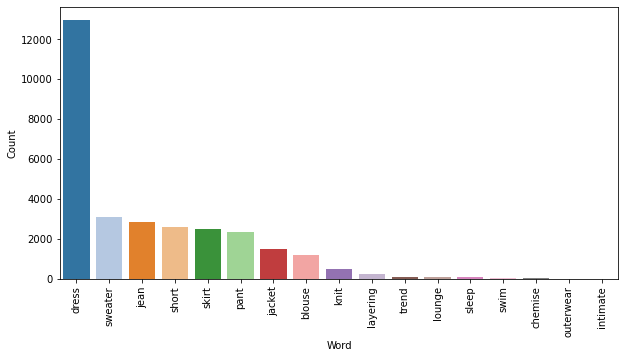

In [46]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Word', y='Count', data=df_products, palette="tab20", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Top Adjectives and Adverbs for Positive vs Negative Reviews

Using Part of Speech taggs, we can look at which adjectives and adverbs people are using most to describe the products.  Below is a table that shows how different parts of speech are encoded in this system.
 
**Part of Speech Codes**

<table align="left" cellpadding="2" cellspacing="2" border="0">
  <tbody><tr bgcolor="#DFDFFF" align="none"> 
    <td align="none"> 
      <div align="left">Number</div>
    </td>
    <td> 
      <div align="left">Tag</div>
    </td>
    <td> 
      <div align="left">Description</div>
    </td>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 7. </td>
    <td>JJ </td>
    <td>Adjective </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 8. </td>
    <td>JJR </td>
    <td>Adjective, comparative </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 9. </td>
    <td>JJS </td>
    <td>Adjective, superlative </td>
  </tr>

  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 20. </td>
    <td>RB </td>
    <td>Adverb </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 21. </td>
    <td>RBR </td>
    <td>Adverb, comparative </td>
  </tr>
  <tr bgcolor="#FFFFCA"> 
    <td align="none"> 22. </td>
    <td>RBS </td>
    <td>Adverb, superlative </td>
  </tr>
  
</td></tr></tbody></table>
 

In [47]:
# Extract pos and neg reviews based on sentiment into their own DFs
df_pos = df[df['sentiment_label'] == 1]
df_neg = df[df['sentiment_label'] == 0]

# Drop the rest of the columns after separating
df_pos = df_pos[['Text_Tok']]
df_neg = df_neg[['Text_Tok']]

In [48]:
def get_top_mods(df_all_words):
    ''' this function will return a dataframe of the top adjetives and 
    adverbs group together and counted'''
    
    df_mods = df_all_words[(df_all_words.P1.str.startswith('JJ')) | (df_all_words.P1.str.startswith('RB'))]

    # Groupby, count, sort in order to get the counts of the words
    df_grouped = df_mods.groupby(['P1', 'Word'])['Word'].count().\
        reset_index(name='count').sort_values(['count'],ascending=False)

    # Convert to Multi-Level Index
    df_grouped.set_index(['P1', 'Word'], inplace=True)

    # Finally, just display the top 3 (if there are 3)
    return df_grouped.groupby(level=0).head(5)

In [49]:
# Build the Dataframe via the Function
df_all_words_pos = build_pos(df_pos['Text_Tok'])

# Get the top words
get_top_mods(df_all_words_pos)

count
P1  Word          
JJ  top       9293
    great     7817
    perfect   4525
    cute      4455
    small     4422
RB  really    3898
    well      3228
    back      3035
    pretty    2755
    also      2403
JJR better    1327
JJS best       642
JJR smaller    616
    shorter    595
    larger     540
JJS least      294
JJR bigger     256
JJS softest     56
    cutest      56
    biggest     47
RBR earlier     41
    sooner       6
    neater       2
    faster       2

In [50]:
# Build the Dataframe via the Function
df_all_words_neg = build_pos(df_neg['Text_Tok'])

# Get the top words
get_top_mods(df_all_words_neg)

count
P1  Word            
JJ  small        476
RB  back         227
JJ  little       211
    thin         183
RB  also         174
    really       171
    even         170
JJ  tight        147
    short        145
RB  usually      124
JJR smaller       36
JJS least         36
JJR shorter       35
    better        30
    larger        29
JJS worst         23
JJR bigger        19
JJS longest        2
RBR faster         2
JJS cutest         2
    strangest      1

**Notes**:

Above are the most frequently occurring positive and negative words per Adjective and Adverb.  

1. **Positive**: Top words are `top`, `great`, `perfect`, `really`, and `pretty`
1. **Negative**: Top words are `small`, `little`, `thin`, `tight`, and `short`

None of the positive words are surprising, but with the negative words, there appears to be a **sizing issue** where products are smaller or larger than people expect vs. the sizes claimed. 

# Sentiment Based Prediction Model:

Next, we'll create a Supervised ML model to predict whether a customer will recommend a product based on the text from the review and the sentiment of that text, and the length of the review.

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline[2].

## Model Selection
During this section, we will use the ColumnTransformer to perform all of the pre-processing steps.  A `FeatureUnion` could also be used but isn't required since we're not transforming the entire numeric data with a PCA process [2].

>*FeatureUnion applies different transformers to the whole of the input data and then combines the results by concatenating them.*  
>*ColumnTransformer, on the other hand, applies different transformers to different subsets of the whole input data, and again concatenates the results.*

In [51]:
X = df[['Text', 'sentiment', 'text_len']]
y = df['sentiment_label']

In [52]:
print(X.shape)
print(y.shape)

(22626, 3)
(22626,)


In [53]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text'),
             ('Text Length', MinMaxScaler(), ['text_len']),
             ('Sentiment', MinMaxScaler(), ['sentiment'])],
            remainder='drop') 
    
    return column_trans

In [54]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [55]:
models = {'ComplementNB' : ComplementNB(),
          'SVC' : SVC(class_weight='balanced', random_state=42),
          'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
          'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

ComplementNB : Mean f1 Macro: 0.642 and Standard Deviation: (0.015)
SVC : Mean f1 Macro: 0.920 and Standard Deviation: (0.014)
LogReg : Mean f1 Macro: 0.895 and Standard Deviation: (0.014)
RandomForest : Mean f1 Macro: 0.899 and Standard Deviation: (0.028)


**Observations**:

The **Support Vector Machine** Classifier performed the best with the **Random Forest** and **Logistic Regression** behind it.  Complement Naive Bayes performed the worst. 

`SVC` is a fairly computationally expensive algorithm [5]; it might be advantageous to use **Logistic Regression** if performance were top priority.

## Model Building

In [56]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [57]:
print(y_train.shape)
print(X_train.shape)

(15159,)
(15159, 3)


In [58]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=-1, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [59]:
parameters = [{'clf__C': np.linspace(.1, 2 ,5), 
               'clf__gamma': [.01, .1, .5], 
               'clf__class_weight' : ['balanced']}]

clf = SVC()
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

svc_C = grid.best_params_['clf__C']
svc_gamma = grid.best_params_['clf__gamma']

Best cross-validation accuracy: 0.917
Test set score: 0.915
Best parameters: {'clf__C': 1.05, 'clf__class_weight': 'balanced', 'clf__gamma': 0.1}


## Model Validation

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [61]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

              precision    recall  f1-score   support

           0      0.766     0.928     0.839       359
           1      0.996     0.986     0.991      7108

    accuracy                          0.983      7467
   macro avg      0.881     0.957     0.915      7467
weighted avg      0.985     0.983     0.984      7467

Confusion matrix, without normalization


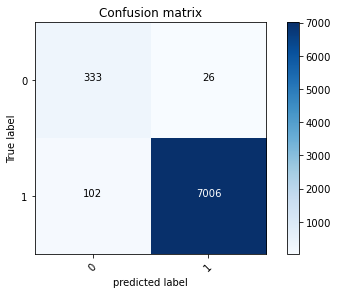

In [62]:
clf = SVC(C=svc_C, gamma=svc_gamma, class_weight='balanced', random_state=42)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'SVC')

**Observations**:

This model performed extremely well across our dataset with an `f1 macro` score of `0.915`.  The dataset has imbalanced, which was corrected for SMOTE (Over Sampling combined with Undersampling).  The result was a very strong predictor model based on `text`, `sentiment`, and `text_len`.

**Synthetic Minority Oversampling Technique** uses a nearest-neighbor approach for generating new minority class samples.  The method is applied only to the training data and then tested on the original, untouched test partition.  The method chosen here is first to oversample the minority class making it balanced, and then undersample it to reduce the size.  This helps bring balance without bloating the dataset [4].

## Test on Custom Data

In [63]:
def create_test_data(x):
    '''calculate the numbers needed to run on custom data including sentiment and text length,
    this is a farily simple process using the fuctions from previous transformations.'''
    
    x = process_string(x)
    sent = get_sentiment(x)
    length = len(x)
    
    d = {'Text' : x,
         'sentiment' : sent,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [64]:
revs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
        'This skirt has really horible quality and I hate it!',
        'A super cute top with the perfect fit.',
        'The most gorgeous pair of jeans I have seen.',
        'this item is too little and tight.']

In [65]:
print('The classifier will return 1 for Positive reviews and 0 for Negative reviews:','\n')
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', c_res)

The classifier will return 1 for Positive reviews and 0 for Negative reviews: 

This dress is gorgeous and I love it and would gladly reccomend it to all of my friends. = [1]
This skirt has really horible quality and I hate it! = [0]
A super cute top with the perfect fit. = [1]
The most gorgeous pair of jeans I have seen. = [1]
this item is too little and tight. = [0]


**Notes**:

Based on our custom strings, each one produced **Correct** classifications with our model.

# Text Classification for Departments

Next, we'll attempt to create a Supervised Machine Learning model to classify products by Department.  This process looks at the text that a user wrote in a review and determined its Department.

An interesting opportunity is to use this information to **cross-sell** or **cross-list** products.  If there is a strong enough probability that an item could be in multiple departments from our analysis, could we **increase sales** with cross-marketing?

## Model Selection

In [66]:
# Tokenize the words
df['Department Name'] = df['Department Name'].apply(word_tokenize)

In [67]:
X = df[['Text', 'Department Name']]
y = df['Department Name']

In [68]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [69]:
print(X.shape)
print(y.shape)
print(mlb.classes_)

(22626, 2)
(22626, 6)
['Bottoms' 'Dresses' 'Intimate' 'Jackets' 'Tops' 'Trend']


In [70]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text')],
            remainder='drop') 
    
    return column_trans

In [71]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans), 
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [72]:
models = {'SVC' : OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1),
          'RF' : OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1),
          'LogReg' : OneVsRestClassifier(LogisticRegression(), n_jobs=-1),
          'Bayes' : OneVsRestClassifier(MultinomialNB(), n_jobs=-1)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=3, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

SVC : Mean f1 Macro: 0.590 and Standard Deviation: (0.013)
RF : Mean f1 Macro: 0.450 and Standard Deviation: (0.011)
LogReg : Mean f1 Macro: 0.582 and Standard Deviation: (0.010)
Bayes : Mean f1 Macro: 0.207 and Standard Deviation: (0.008)


**Notes**:

Again the `SVC` classifier performed the best with `LogisticRegression` coming out second best.   `MultinomialNB` perfrormed the worst out of these.

## Model Building & Validation

In [73]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [74]:
print(y_train.shape)
print(X_train.shape)

(15159, 6)
(15159, 2)


In [75]:
# Note: Optimization was performed prior to Hyperparemeter selection
clf = OneVsRestClassifier(SVC(C=.5, gamma=.1, kernel='linear', 
                              class_weight='balanced', random_state=42))
pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro')

print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.707     0.842     0.768      1175
           1      0.823     0.894     0.857      2068
           2      0.309     0.663     0.422       523
           3      0.490     0.700     0.576       340
           4      0.802     0.893     0.845      3323
           5      0.083     0.026     0.040        38

   micro avg      0.713     0.856     0.778      7467
   macro avg      0.536     0.670     0.585      7467
weighted avg      0.740     0.856     0.790      7467
 samples avg      0.752     0.856     0.786      7467



**Observations**:

 - There are very few observations in the `5` class overall in the dataset.  You can see in the support column for this class only `38` samples are present.  Through synthetic oversampling (SMOTE), we could get a small precision and recall score, but it's difficult without more observations.
 - The `2` and `3` classes are also smaller and therefore do not have as high an `f1` score.
 - The remainder of the classes are all performing very well.  
 - The `f1 macro` score is `~.6`, which normally is not considered a good score, but in the case of multi-value classification, it doesn't necessarily mean it's a poor-performing model.  We can test this thorough inspection of the actual predictions.

In [76]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Labels'] = pred_labels

In [77]:
# Display a random sample of them
pd.set_option('display.max_colwidth', -1)
X_test.sample(10, random_state=60)

,Text,Department Name,Predicted Labels
12739,"Perfect denim dress Strapless dresses can be so flattering so when i saw this on retailer i had to order it! this dress did not disappoint. for reference i ordered a size 4 and i am 5'5"", 135 lbs, 34b chest. in the chest area it fits perfectly, while the ribcage area is a little snug, but not uncomfortably so. the pockets are great. the denim quality is great. and i like the frayed bottom of dress. i got compliments straight away on the beauty of the dress from two men. which i thought was quite interesting because i",[Dresses],"(Dresses,)"
8442,"Reminds me of my mamaw I got these in the mail today and to me, they look exactly like the pants my mamaw used to wear in the 80s. they were super comfy but not cute at all on me. they do run large like other reviews say. i am usually an 8/10 or med and these in the small were the right choice. going back because they just look horrible on me though",[Bottoms],"(Bottoms,)"
12643,"Pilcro faux fur denim jacket Denim, faux fur, flannel... hooray! i absolutely love this jacket and i'll wear it all winter (even under my warmer winter coat). i'm 5'6""/130 and usually a 2-4 in retailer and the small in this coat was plenty big in the waist/chest and even had room underneath to add a second shirt or light sweater. it seems a little shorter on me than in the photo... maybe that's the only drawback.",[Jackets],"(Jackets,)"
4451,"This is cute! i've been so looking forward to it, but it's big!! i'm usually a small in retailer size, medium most of the time otherwise. i ordered the medium, but it's way too big. doesn't fit at all like the pictures. sadly, it's going back, hopefully for a much smaller size. but other than this, it's lovely",[Tops],()
1023,"Cozy, flattering, and practical At first, i thought this sweater might be too boxy, but fastened at the waist, it's very flattering and the collar is face-framing, and the coral in particular (really more of a mango sorbet shade) is unexpected but cheery for winter.\n\nbut the big selling point is the warmth and the giant pockets. brought a new puppy home just after christmas, and this sweater is perfect for layering for late- night trips out with an easy place to stash my phone and treats. bought it in coral and pink.",[Tops],"(Intimate, Tops)"
18632,"Purple motif I like the look and fit of this shirt. can be dressed up or more casual. i got the purple motif, although i also like the brown and think that with all of the black in there (on the brown one) it would give a dressier look. i usually wear small from retailer, although this is my first blouse from this brand -- ended up getting an xs regular. i wanted the sleeves to fit at 3/4 as shown in the pics, but still be loose. i had a ton of extra room in the small, and the sleeves hit at wrist bone",[Tops],"(Tops,)"
6109,"Hard one to review I had a really, really difficult time reviewing this dress. the instant i touched it, i wanted to love it! in theory, it should have worked for me. fit and flare is usually a really great option for my pear shape. the silhouette shows off my thinner upper body and camouflages my thicker lower body. best of both worlds! however, as you can see for yourself in the photo, this dress makes me look pretty big. i'm a solid size 8 and i feel this dress makes me look like a 12. it really makes my middle",[Dresses],"(Dresses,)"
6930,"Unique white top Although it kind of ran big and the material is stiff causing some protrusion off my shoulders, i decided to keep it only because it was unique and still looked cute",[Tops],"(Tops,)"
10302,"Light and sweet Online this jacket is supposedly an online exclusive, but i saw it in green at my local store. i had to try it on and i loved it. it does swing but is not to much fabric. the drape is really nice it is shorter in the front and longer in the back. it sort of shows that on the model but is much more noticeable in person. this jacket is not lined and i would say more of a shi

**Observations:**

 - In many cases, our classifier was very accurate in determining the correct Department.  Since we used a multi-label classifier, the algorithm suggested more than one label in some cases.  Upon inspecting these, in some cases, the suggestion of an additional Department is incredibly logical.  
 - One item in the above list did not receive a predicted label.
 - Two are showing multiple classes, but in one of these cases, they make sense.  `Jackets` and `Tops`.  For the other, it's classifying it as `Intimate` and `Tops`, which probably would not apply.
 - There is one misclassified item.  The original class was `Trend`, and the predicted class is `Bottoms` for this skirt.  However, a skirt is a bottom and therefore is correct.  We also do not have many observations in the `Trend` class; therefore, it's harder to be accurate with predictions here, as we noted earlier.
 - It's possible to use these multi-label classes to investigate **cross-marketing / cross-listing** opportunities for these products.  

## Test on New Data

In [78]:
def create_test_data(x):
    '''create a dataframe that is in the same format as the Train and Test Data.
    ['Bottoms' 'Dresses' 'Intimate' 'Jackets' 'Tops' 'Trend']'''
    
    s = process_string(x[0])
    
    d = {'Text' : s,
         'Department Name' : x[1]}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [79]:
revs = [('This dress is gorgeous and would gladly reccomend it to all of my friends.', ['Dresses']),
     ('These pants have really horible quality and I hate them!', ['Bottoms']),
     ('A super cute blouse with a great fit.', ['Tops']),
     ('The most gorgeous pair of jeans I have seen.', ['Bottoms']),
     ('This bra is silky smooth material and fits perfectly.', ['Intimate'])]

In [88]:
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev[0], '\n', rev[1], '\n' ,mlb.inverse_transform(c_res), '\n')

This dress is gorgeous and would gladly reccomend it to all of my friends. 
 ['Dresses'] 
 [('Dresses',)] 

These pants have really horible quality and I hate them! 
 ['Bottoms'] 
 [('Bottoms',)] 

A super cute blouse with a great fit. 
 ['Tops'] 
 [('Tops',)] 

The most gorgeous pair of jeans I have seen. 
 ['Bottoms'] 
 [('Bottoms', 'Tops')] 

This bra is silky smooth material and fits perfectly. 
 ['Intimate'] 
 [('Bottoms', 'Dresses', 'Intimate')] 



**Observations**:  

- The first three sample sentences do not have a problem with the classification.  They do contain keywords that are highly related to the Department names.  `Dress`, `Pants`, and `Blouse`.  
- The fourth sentence miss-classified with a match to both `tops` and `bottoms`.
- The fifth sentence also miss classified with getting one correct, but miss matching on `bottoms` and `dresses`.

# Conclusion

**Parts of Speech**  

The most interesting takeaway from this portion of the exercise was the negative adjectives and adverbs.  These descriptors of the products help point us in a direction we might not have been previously aware.  For example, the following top words identified above:

 - **Positive**: Top words are `top`, `great`, `perfect`, `really`, and `pretty`
 - **Negative**: Top words are `small`, `little`, `thin`, `tight`, and `short`

The negative words suggest there appears to be a **clothing size issue** where products are smaller or larger than people expect vs. the sizes claimed.  I would strongly suggest we review how clothes are labeled and potentially let customers offer a **True to Size** feedback option. 

**Sentiment Analysis**

 - Our model to predict recommendations based on sentiment was very accurate.  Using the `SVC` classifier tuned to the model, we achieved about a `0.915` accuracy in our test data set predictions.  With `91.5%` confidence, we can determine how a person will rate our products based on the reviews they write.

**Department Classification**

- This exercise proved interesting as well.  While the overall performance (as measured by `f1 macro`) was not as strong as the sentiment-based model, it also provided different points of view we could not achieve otherwise.  In the sample selections, we can see that those were often quite relevant to the prediction cases where it misclassified with multiple categories/departments.  Therefore it might be possible to **cross-list/market** products in these categories.




# References

1. https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.tags
1. https://stackoverflow.com/questions/55604249/featureunion-vs-columntransformer
1. https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/
1. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
1. https://sklearn.org/modules/svm.html#complexity